In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import html

# PARAMETERS
emotion_data_size = 16000
hateSpeechBalanced_size = 7000
#assert emotion_data_size + hateSpeoechBalanced_size == 18000

# ================== Process text.csv (emotion data) =======================
emotions_df = pd.read_csv("TrainingData/text.csv")
emotions_df.drop(columns=['Unnamed: 0'], inplace=True)

# Split into 'feeling' and 'no feeling' texts
no_feeling_size = int(emotion_data_size / 2)
feeling_size = int(no_feeling_size / 5)

feeling_df = emotions_df[emotions_df['text'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)]
no_feeling_df = emotions_df[~emotions_df['text'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)].sample(n=no_feeling_size, random_state=42).copy()

emotions = pd.DataFrame()
for i in range(0, 5):
    temp = feeling_df[feeling_df['label'] == i].sample(n=feeling_size, random_state=42).copy()
    emotions = pd.concat([emotions, temp], ignore_index=True)

emotions = pd.concat([emotions, no_feeling_df], ignore_index=True)
emotions['Content'] = emotions['text']
emotions['Label'] = 0  # all emotion data treated as clean
emotions.drop(columns=['text', 'label'], inplace=True)

# ****** append column that states which csv file each row came from, for the purpose of creating visuals
# should proabbly change the names of the original csv files themselves for clarity but i feel like we're already in too deep lmfao
emotions['FileSource'] = 'emotion_tweets_clean.csv'
# emotions['word_count'] = emotions['Content'].astype(str).apply(lambda x: len(x.split()))


# ================== Process labeled_data.csv =======================
df1 = pd.read_csv("TrainingData/labeled_data.csv")
df1 = df1[['tweet', 'class']]

hatespeech_ld = df1[df1['class'] == 0].sample(n=1430, random_state=42).copy()
clean_ld = df1[df1['class'] == 2].sample(n=1430, random_state=42).copy()

labeled_data = pd.concat([hatespeech_ld, clean_ld], ignore_index=True)
labeled_data['Content'] = labeled_data['tweet']
labeled_data['Label'] = labeled_data['class'].replace({0: 1, 2: 0})
labeled_data.drop(columns=['tweet', 'class'], inplace=True)
# labeled_data['word_count'] = labeled_data['Content'].astype(str).apply(lambda x: len(x.split()))
labeled_data['FileSource'] = 'crowdsourced_labels.csv'

hatespeech_dataset = pd.read_csv("TrainingData/HateSpeechDatasetBalanced.csv")
hatespeech_dataset['wordCount'] = hatespeech_dataset['Content'].astype(str).apply(lambda x: len(x.split()))
# maybe for training, i should make sure there isn't a bias towards word count 



In [28]:


# ================== Process HateSpeechDatasetBalanced.csv =======================
df2 = pd.read_csv("TrainingData/HateSpeechDatasetBalanced.csv")
df2 = df2[['Content', 'Label']]

# Subsample from df2 to match hateSpeechBalanced_size
hs_size = 25000
non_hs_size = hs_size-emotion_data_size

hs_df = df2[df2['Label'] == 1].sample(n=hs_size, random_state=42).copy()
clean_df = df2[df2['Label'] == 0].sample(n=non_hs_size, random_state=42).copy()
balanced_df = pd.concat([hs_df, clean_df], ignore_index=True)
balanced_df['FileSource'] = 'balanced_hatespeech.csv'

# ================== Final Merge =======================
# Combine emotion data, balanced hateSpeech data, and labeled_data.csv
training_data_df = pd.concat([emotions, balanced_df, labeled_data], ignore_index=True)

# ================== Cleaning =======================
training_data_df['Content'] = training_data_df['Content'].astype(str).str.casefold()

# Unescape emojis (from &#12345; to actual emoji)
training_data_df['Content'] = training_data_df['Content'].apply(html.unescape)

# Basic cleaning: remove mentions and links
training_data_df['Content'] = training_data_df['Content'] \
    .str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True) \
    .str.replace(r'http\S+', ' ', regex=True)

training_data_df['word_count'] = training_data_df['Content'].astype(str).apply(lambda x: len(x.split()))

# ================== Save =======================
training_data_df.to_csv('combinedlabel.csv', index=False) #named this after Bert Model cuz i was only training bert at the time and didnt wanna get confused when i come back

# ================== Summary =======================
print(training_data_df['Label'].value_counts())
print("✅ Combined dataset size:", training_data_df.shape)

Label
0    26430
1    26430
Name: count, dtype: int64
✅ Combined dataset size: (52860, 4)


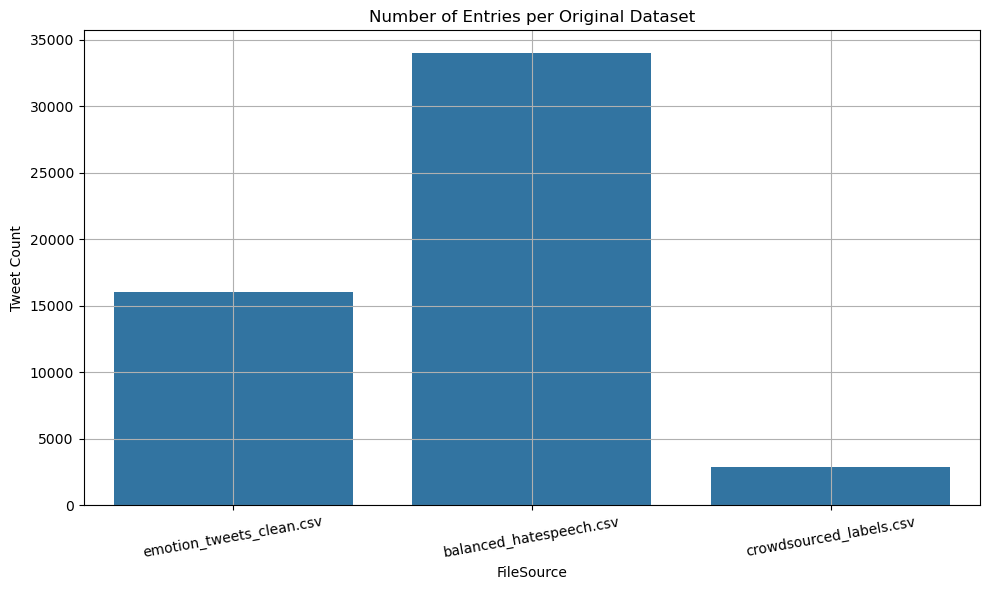

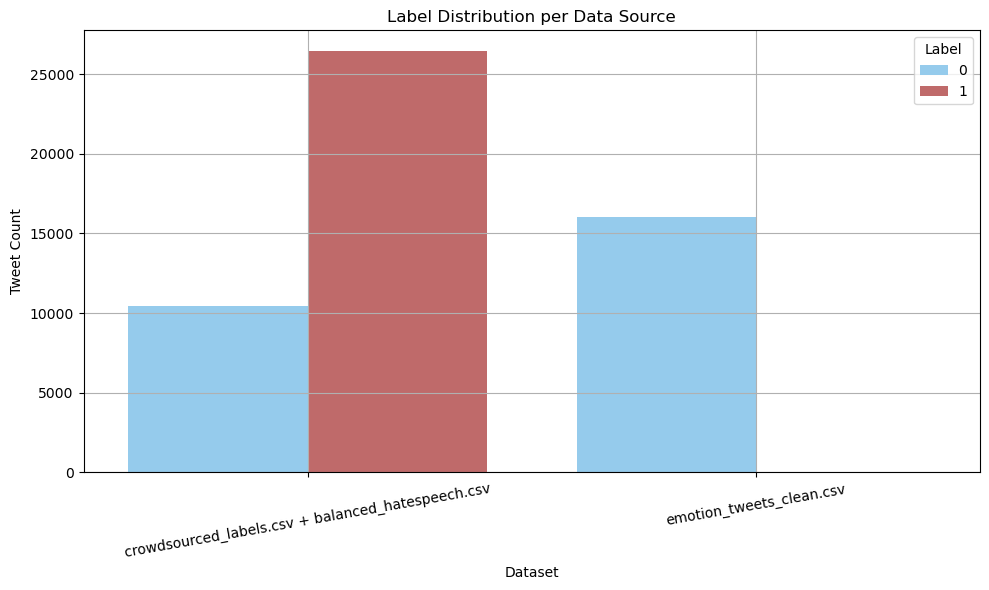

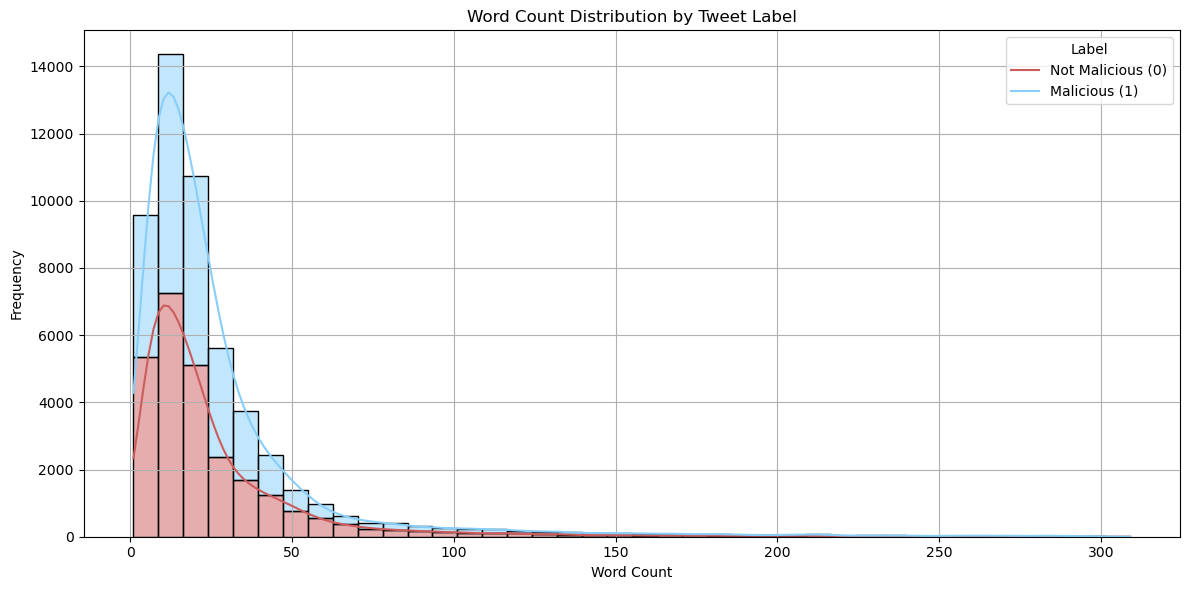

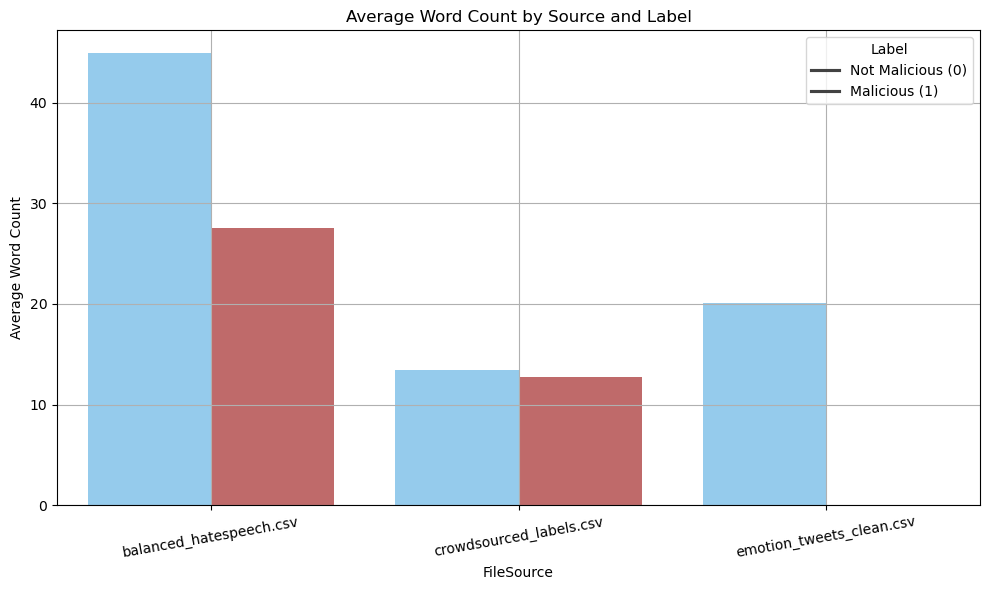

,Content,Label,FileSource,word_count,Dataset
0,i feel nothing i feel worthless and pain and i...,0,emotion_tweets_clean.csv,18,emotion_tweets_clean.csv
1,i instantly become terrified but it was the di...,0,emotion_tweets_clean.csv,19,emotion_tweets_clean.csv
2,i want seem to be pulling me in different dire...,0,emotion_tweets_clean.csv,19,emotion_tweets_clean.csv
3,i write this short post for any and all of you...,0,emotion_tweets_clean.csv,20,emotion_tweets_clean.csv
4,i don t have any money for beauty supplies or ...,0,emotion_tweets_clean.csv,18,emotion_tweets_clean.csv
...,...,...,...,...,...
52855,"if someone pushes you too hard today, they may...",0,crowdsourced_labels.csv,15,crowdsourced_labels.csv + balanced_hatespeech.csv
52856,beanies cumming real soon,0,crowdsourced_labels.csv,4,crowdsourced_labels.csv + balanced_hatespeech.csv
52857,"stuff broke loose, must not panic and share ...",0,crowdsourced_labels.csv,10,crowdsourced_labels.csv + balanced_hatespeech.csv
52858,early bird catches the worm 👌,0,crowdsourced_labels.csv,6,crowdsourced_labels.csv + balanced_hatespeech.csv


In [34]:

df = pd.read_csv("combinedlabel.csv")



custom_palette = {0: 'lightskyblue', 1: 'indianred'}

# bar chart of data source counts 
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='FileSource')
plt.title('Number of Entries per Original Dataset')
plt.ylabel('Tweet Count')
plt.xticks(rotation=10)
plt.grid(True)
plt.tight_layout()
plt.show()


df['Dataset'] = df['FileSource'].apply(
    lambda x: 'emotion_tweets_clean.csv' if x == 'emotion_tweets_clean.csv' else 'crowdsourced_labels.csv + balanced_hatespeech.csv')


# bar chart that captures how the aggreggated csv is comprised of ratios of each csv file, for each label
source_label_counts = df.groupby(['Dataset', 'Label']).size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(data=source_label_counts, x='Dataset', y='Count', hue='Label', palette=custom_palette)
plt.title('Label Distribution per Data Source')
plt.ylabel('Tweet Count')
plt.xticks(rotation=10)
plt.legend(title='Label')
plt.grid(True)
plt.tight_layout()
plt.show()

# word count column

# word count distribution of malicious tweets vs. non malicious tweets
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='Label', bins=40, kde=True, multiple='stack', palette=custom_palette)
plt.title('Word Count Distribution by Tweet Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Not Malicious (0)', 'Malicious (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()

# avg word count per source and label 
avg_word_counts = df.groupby(['FileSource', 'Label'])['word_count'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_word_counts, x='FileSource', y='word_count', hue='Label', palette=custom_palette)
plt.title('Average Word Count by Source and Label')
plt.ylabel('Average Word Count')
plt.xticks(rotation=10)
plt.legend(title='Label', labels=['Not Malicious (0)', 'Malicious (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()

# # pie chart for fun
# label_counts = df['Label'].value_counts()
# plt.figure(figsize=(6, 6))
# plt.pie(label_counts, labels=['Not Malicious (0)', 'Malicious (1)'],
#         autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
# plt.title('Malicious vs Non-Malicious Tweet Distribution')
# plt.tight_layout()
# plt.show()
# how word dis of 
df

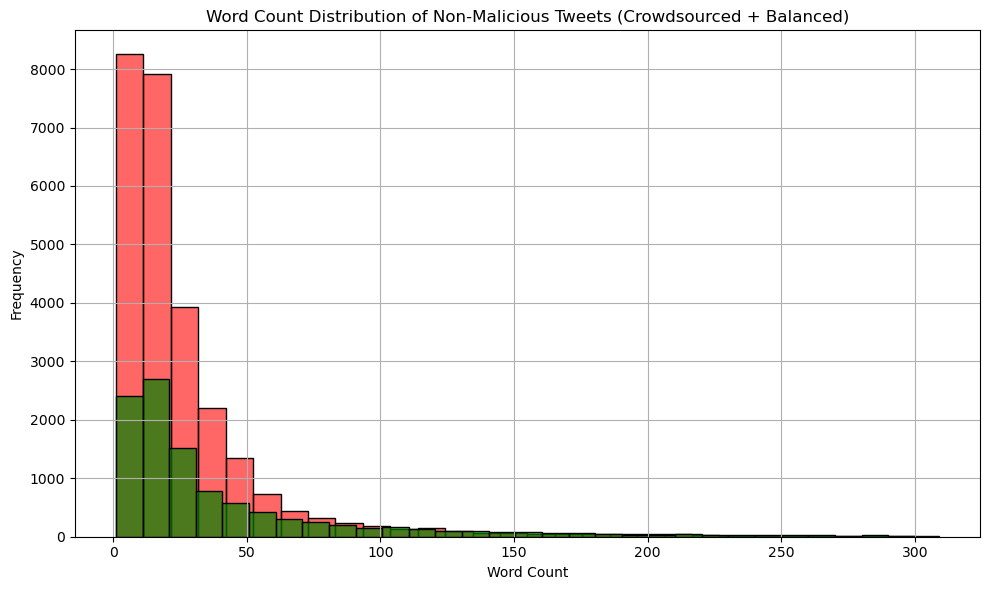

In [40]:
# Filter the DataFrame
subset = df[(df['Label'] == 0) & (df['Dataset'] == 'crowdsourced_labels.csv + balanced_hatespeech.csv')]
subset2 = df[(df['Label'] == 1) & (df['Dataset'] == 'crowdsourced_labels.csv + balanced_hatespeech.csv')]

# Plot word count histogram
plt.figure(figsize=(10, 6))
sns.histplot(subset2['word_count'], bins=30, color='red', kde=False,alpha=0.6)
sns.histplot(subset['word_count'], bins=30, color='green', kde=False,alpha=0.7)

plt.title("Word Count Distribution of Non-Malicious Tweets (Crowdsourced + Balanced)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
df2 = df[df['Label']==1].copy()
df2

,Content,Label,FileSource,word_count
16000,just some trump supper voicing their thoughts ...,1,HateSpeechDatasetBalanced.csv,18
16001,it live my damn varlet and i can do what i wan...,1,HateSpeechDatasetBalanced.csv,14
16002,so said i what sounds a slut right you are rea...,1,HateSpeechDatasetBalanced.csv,47
16003,it is all talk about my bullshit index pointin...,1,HateSpeechDatasetBalanced.csv,21
16004,i do not know why but i have such a disdain fo...,1,HateSpeechDatasetBalanced.csv,18
...,...,...,...,...
51425,all deze hoes got past demons in em... yol...,1,labeled_data.csv,13
51426,lmaoooo what a bunch of fags,1,labeled_data.csv,6
51427,this kid looks like a retard when he tries hid...,1,labeled_data.csv,14
51428,jennifer lawrence's nudes sooooo trash. im sti...,1,labeled_data.csv,11


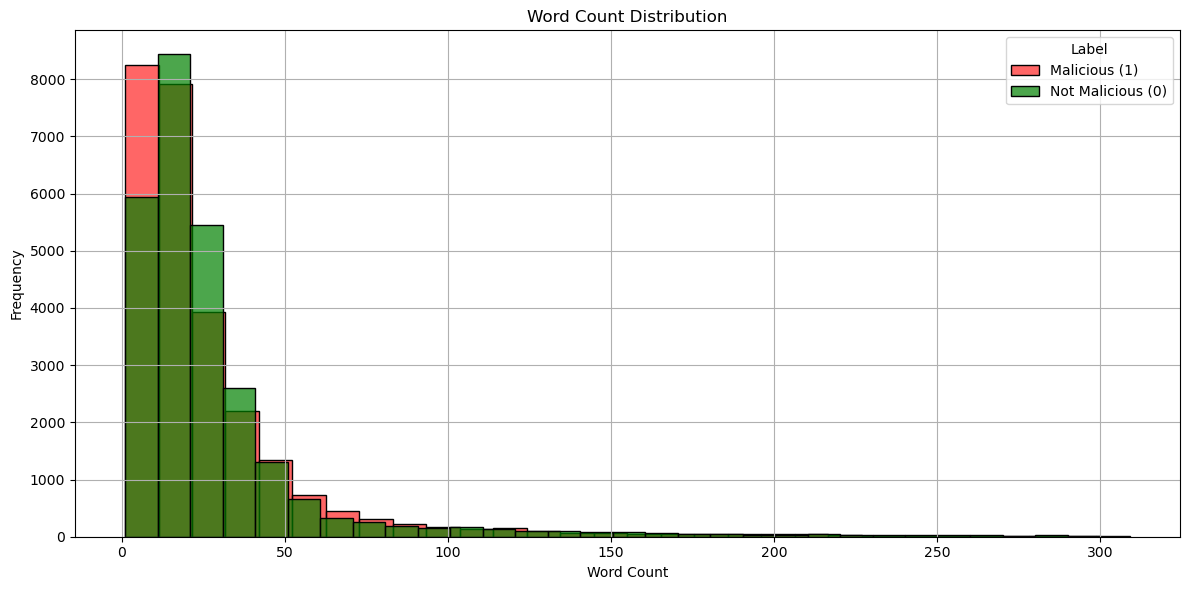

In [45]:
df3 = df[df['Label']==0].copy()
df1 = df[df['Label']==1].copy()


plt.figure(figsize=(12, 6))
sns.histplot(df1['word_count'], bins=30, color='red', label='Malicious (1)', kde=False, alpha=0.6)
sns.histplot(df3['word_count'], bins=30, color='green', label='Not Malicious (0)', kde=False, alpha=0.7)


plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title="Label")
plt.grid(True)
plt.tight_layout()
plt.show()
